<h1 style='text-align:center'><b>Hotel Booking Cancellation Prediction</b></h1>

<b id="intro"></b>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;"> Introduction </p>

**Context**: The hotel industry has been consistently growing, with the global hotel industry revenue on the rise. According to the Hospitality Global Market Report 2024, it will grow from $4673.63 billion in 2023 to $4993.71 billion in 2024 at a compound annual growth rate (CAGR) of 6.8%. Effective management of hotel bookings is crucial for maximizing revenue and optimizing operational resources. [Source](https://www.researchandmarkets.com/report/hospitality)

One of the most significant challenges currently facing the hospitality industry is the number of canceled reservations. In recent years, the prevalence of online travel agents offering free cancellation has led to a notable increase in cancellation rates. This is because customers can reserve rooms without immediate financial commitment and continue to search for better deals.Interestingly, some customers make multiple reservations to secure the best deal, contributing to the high cancellation rates.

The stakeholders who would be interested and impacted by the insights from my analysis is hotel management. Hotel management, including revenue managers and general managers, would be concerned with maximizing revenue and minimizing losses due to cancellations, while also focusing on overall hotel operations and customer satisfaction


**Problem Statement**: The hospitality industry faces substantial revenue loss and operational difficulties due to hotel booking cancellations. Predicting cancellations in advance would enable hotels to proactively mitigate these impacts. Yet, traditional methods such as historical data analysis or manual risk assessments are often labor-intensive or unreliable.

**Objective**: This project aims to develop a machine learning classification model for predicting hotel booking cancellations. By leveraging historical booking data and various associated features, the goal is to build a model that accurately classifies bookings as either "Canceled" (1) or "Not Canceled" (0). This model will empower hotel managers to allocate resources more effectively and optimize inventory management, thereby reducing potential revenue loss from cancellations.

<b>Analytical Approach</b>
- <b>Step-1</b>: Perform an exploratory data analysis (EDA) to understand the characteristics of data before building a classification model.
- <b>Step-2</b>: Build a classification model to predict the probability of customers canceling their hotel booking.
- <b>Step-3</b>: Identify key factors underlie the cancelation of hotel bookings.

<b>Metrics</b>: The focus of this analysis lies in mitigating the impact of false negatives (Type II errors), as they pose a higher financial risk to the hotel. However, a consideration is also given to minimizing false positives (Type I errors) to maintain operational efficiency.
- <b>Type I Error (False Positive)</b>: When the model incorrectly identifies a booking as canceled (Type I error), it may lead to overbooking or unnecessary actions by the hotel such as providing compensation to guests by offering similar or better room types.
	- Assuming an average loss is between USD13 and USD59 per false positive to upgrade hotel rooms, the total monthly loss will be in the range of USD1300 to USD5900 for 100 errors according to [Source](https://bettertravel.ai/hotel-prices/portugal). 
- <b>Type II Error (False Negative)</b>: When the model fails to predict a cancellation (Type II error), the hotel may lose revenue equivalent to the average price of a hotel room. In Portugal, this amounts to USD110  per night according to [Source](https://bettertravel.ai/hotel-prices/portugal).
	- Assuming the model makes 100 false negatives in a month, the total financial loss for the hotel could reach USD1106


Given the higher financial implications of Type II errors, the primary focus of the classification model is to minimize their occurrence. Therefore, the main evaluation metric for model performance will be $F_2$ score which provides a balanced consideratrion of precision and recall, with greater emphasis on recall to reduce Type II errors.


<a id="import"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 1 | Import Libraries</p>

In [1]:
# importing libraries
# algorithm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier

# preprocessing
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from imblearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.compose import ColumnTransformer

# metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, make_scorer, fbeta_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import shap

# statistical test 
from scipy.stats import skew, kurtosis, kstest, shapiro

# data manipulation
import pandas as pd
import numpy as np
from math import ceil

# saving model
import pickle

# resampling method 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# warning handling
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
warnings.filterwarnings("ignore")

# maximizing columns and columns width
pd.set_option("display.max_colwidth", 1)
pd.set_option('display.max_columns', None)

<a id="read"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 2 | Read Dataset</p>

In [2]:
# read dataset 
df = pd.read_csv('data_hotel_booking_demand.csv')
display(df.head(), df.tail())

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
83572,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1


<h3 align="left"><font color=royalblue>Dataset Description:</font></h3>

| __Index__ | __Variable__ | __Description__ |
|   :---    |     :---     |       :---      |
| 1 | __is_canceled__ | Reservation cancellation status (0 = not canceled, 1 = canceled) |
| 2 | __country__ | Country of origin of the guest |
| 3 | __market_segment__ | Market segment designation |
| 4 | __previous_cancellations__ | Number of previous bookings that were canceled by the customer |
| 5 | __reserved_room_type__ | Type of reserved room |
| 6 | __booking_changes__ | Number of changes made to the booking |
| 7 | __deposit_type__ | Type of deposit made (No Deposit, Refundable, Non Refund) |
| 8 | __days_in_waiting_list__ | Number of days the booking was in the waiting list |
| 9 | __customer_type__ | Type of customer (Transient, Contract, Transient-Party, Group) |
| 10 | __required_car_parking_spaces__ | Number of car parking spaces required |
| 11 | __total_of_special_requests__ | Number of special requests made |


<a id="overview"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 3 | Dataset Overview</p>

<a id="basic"></a>
# <b><span style='color:darkturquoise'>Step 3.1 |</span><span style='color:royalblue'> Dataset Basic Information</span></b>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


> ### **Insight** :
- __Number of Entries__: The dataset consists of __83573 entries__.
- __Columns__: The dataset contains __11 columns__, which represent various attributes related to hotel bookings.
- __Data Types__:
    * A majority of the columns, 5 to be precise, are of the __object__ data type (often representing strings or categorical data).
    * 6 columns are of the __int64__ data type, representing integer values.
- __Missing Values__: 
    * The column `country` has 351 missing values. These missing values might need addressing, depending on the context of the analysis or the model we intend to build.

<a id="numerical"></a>
# <b><span style='color:darkturquoise'>Step 3.2 |</span><span style='color:royalblue'> Summary Statistics for Numerical Variables</span></b>

In [4]:
# get summary statistic for numerical features 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
previous_cancellations,83573.0,0.086798,0.841011,0.0,0.0,0.0,0.0,26.0
booking_changes,83573.0,0.220897,0.648635,0.0,0.0,0.0,0.0,21.0
days_in_waiting_list,83573.0,2.330561,17.673051,0.0,0.0,0.0,0.0,391.0
required_car_parking_spaces,83573.0,0.062999,0.246919,0.0,0.0,0.0,0.0,8.0
total_of_special_requests,83573.0,0.573211,0.795163,0.0,0.0,0.0,1.0,5.0
is_canceled,83573.0,0.368277,0.482340,0.0,0.0,0.0,1.0,1.0


> ### **Insight** :
- __`previous_cancellations`__: On average, guests have canceled about 0 times in the past, with some guests having as many as 26 previous cancellations.
- __`booking_changes`__: Bookings are changed on average about 0 times, with some bookings being changed up to 21 times.
- __`days_in_waiting_list`__: The average time a booking spends on the waiting list is approximately 2.33 days, with some bookings waiting for as long as 391 days.
- __`required_car_parking_spaces`__: On average, guests require about 0 parking spaces, with some bookings requiring up to 8 spaces.
- __`total_of_special_requests`__: On average, guests make about 0 special requests, with some making up to 5 requests.

<a id="categorical"></a>
# <b><span style='color:darkturquoise'>Step 3.3 |</span><span style='color:royalblue'> Summary Statistics for Categorical Variables</span></b>

In [5]:
# get summary statistic for categorical features
df.describe(include='object').T

,count,unique,top,freq
country,83222,162,PRT,34097
market_segment,83573,8,Online TA,39460
deposit_type,83573,3,No Deposit,73352
customer_type,83573,4,Transient,62732
reserved_room_type,83573,10,A,60041


> ### **Insight** :
- __`country`__: 162 unique countries of origin are present. The most frequent country is "PRT" (Portugal), observed 34097 times.
- __`market_segment`__: 8 unique market segments are present. The most common segment is "Online TA", observed 39460 times.
- __`reserved_room_type`__ : Various room types are present, with some types being more frequent than others.
- __`deposit_type`__: 3 unique types of deposits are made. The most common type is "No Deposit", observed 73352 times.
- __`customer_type`__: 4 unique customer types are present. The most frequent type is "Transient", observed 62732 times.

<a id="EDA"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 4 | Exploratory Data Analysis </p>

<a id="distribution"></a>
# <b><span style='color:darkturquoise'>Step 4.1 |</span><span style='color:royalblue'> Check Distribution Data</span></b>

In [6]:
# check data distribution: Numerical variables
df_numeric = df.select_dtypes(include='number')

ks_pvalues = df_numeric.apply(lambda col: kstest(col, 'norm')[1]).values
sw_values = df_numeric.apply(lambda col: shapiro(col)[1]).values

pd.DataFrame({'column': df_numeric.columns,
              'skewness': df_numeric.apply(skew).round(2).values,
              'kurtosis': df_numeric.apply(kurtosis).round(2).values,
              'ks_pvalue': ks_pvalues.round(2),
              'sw_pvalues': sw_values.round(2)
})

,column,skewness,kurtosis,ks_pvalue,sw_pvalues
0,previous_cancellations,24.41,673.23,0.0,0.0
1,booking_changes,6.00,81.72,0.0,0.0
2,days_in_waiting_list,11.89,184.73,0.0,0.0
3,required_car_parking_spaces,4.33,36.70,0.0,0.0
4,total_of_special_requests,1.35,1.50,0.0,0.0
5,is_canceled,0.55,-1.70,0.0,0.0


> ### **Insight** :
- With <i>p</i>-values of both Kolmogorov-Smirnov and Shapiro-Wilk tests, all data in all columns indicate deviation from the normal distribution.
- The table also informs about the skewness (symmentry of the distribution) and kurtosis (peakedness/flateness of the distribution). The values on the tables indicate substantial non-normality given their large magnitudes.
    - `previous_cancellations`: The skewness and kurtosis values are very high, indicating a highly skewed distribution with a long tail on the positive side. Due to the skewness, it is likely that this variable contains outliers. However, this will be further explored in the following sections.
    - `booking_changes`: These two values are also high, although not as high as the first variable.
    - `days_in_waiting_list`: Both skewness and kurtosis values are high, indicating a highly skewed distribution with heavy tails.
    - `total_of_special_request`: Given that the kurtosis is relatively low, the peak is more typical than the previous variable.
    - `is_canceled`: A negative kurtosis value indicates that the distribution looks slightly flatter than the norm.

<a id="categorical_eda"></a>
# <b><span style='color:darkturquoise'>Step 4.2 |</span><span style='color:royalblue'> Categorical Variables</span></b>

In [7]:
def stack_bar_chart(list_colom):
    """
    Generate stacked bar charts showing cancellation rates across specified columns.
    """
    if len(list_colom) <= 3:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
    else:
        fig, axes = plt.subplots(nrows=ceil(len(list_colom)/3), ncols=3, figsize=(17, 14))
    for i, column in enumerate(list_colom):
        if len(list_colom) <= 3:
            ax = pd.crosstab(df[column], df['is_canceled'], normalize='index').plot.barh(stacked=True, ax = axes[i])
        else:
            ax = pd.crosstab(df[column], df['is_canceled'], normalize='index').plot.barh(stacked=True, ax = axes[i // 3, i % 3])
        ax.legend(bbox_to_anchor=(0.5, 0.5), title='is_canceled', fontsize=5, title_fontsize=10, labels=['No', 'Yes'], loc='lower left')
        ax.legend().remove()

        j = 1
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.text(x+width/2, y+height/2, '{:.1f} %'.format(width*100),  
                    horizontalalignment='center', verticalalignment='center',
                    color='white', fontsize=8, weight='bold')
            j += 1

        ax.set_title(f'Cancelation Rate by {column}', fontsize=12, pad=10)
        ax.set_xlabel('Percentage (%)', fontsize=12, labelpad=5) 
        ax.set_ylabel(column, fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

    plt.tight_layout()
    plt.show()

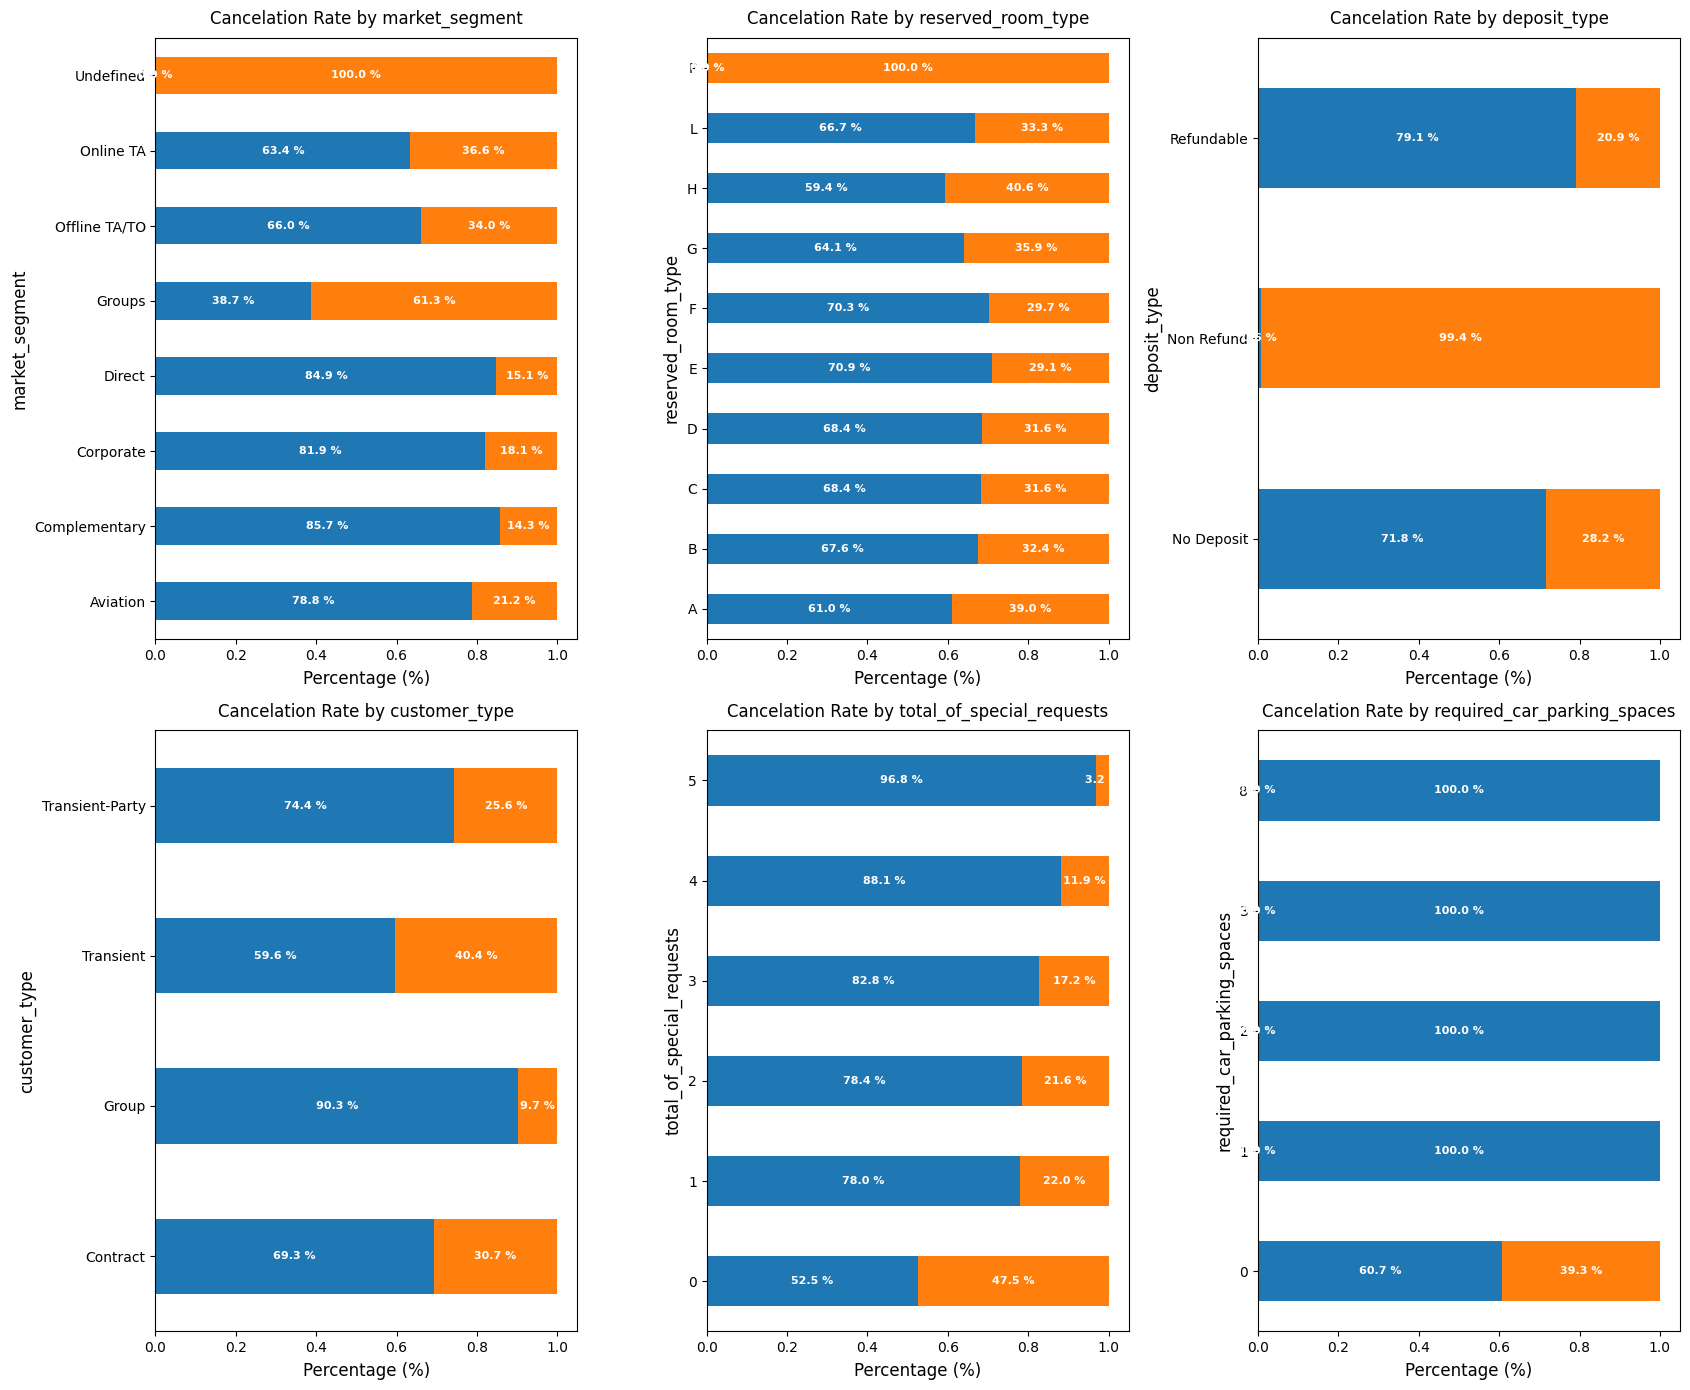

In [8]:
columns_to_plot = ['market_segment', 'reserved_room_type', 'deposit_type', 'customer_type','total_of_special_requests', 'required_car_parking_spaces']
stack_bar_chart(columns_to_plot)

> ### **Insight** :
- In the `market segment` it seems that the market segment group has a high cancelation rate of 61%. More than half of the customers who booked a hotel in that market segment then canceled their booking. This could be an indication that there are certain challenges or issues that influence customers in that segment to cancel their hotel bookings. The market segment with the highest cancellation rate is the "Undefined" segment at 100%. However, since there is only one row with this value, it will be removed from the dataset for further analysis. 
- In `reserved_room_type` the "P" room type shows a 100% cancellation rate, though this may be due to a small sample size. Most other room types have cancellation rates ranging from approximately 31.6% to 40.6%, indicating some variation but generally around one-third of bookings being canceled.
- Customers with a "Non Refund" deposit type have a very high cancellation rate at 99.4%, showing that non-refundable deposits might not deter cancellations effectively. Those with "No Deposit" have a cancellation rate of 28.2%, which is lower but still significant. Customers with a "Refundable" deposit type have the lowest cancellation rate at 20.9%.
- `customer_type` Transient memiliki tingkat pembatalan yang cukup tinggi yaitu sebesar 40.4%.
- It can be seen that the more customers who request `special requests`, the lower the cancellation rate. Customers who do not request special requests have a cancellation rate of 47.5%, while if there is a request the cancellation rate is less than 23%. This shows that customers tend to be more satisfied and more likely to continue with their booking if their special requests are met.
- customers who do not `required_car_parking_space` have a high cancellation rate of 39.3% compared to customers who request vehicle parking whose cancellation rate is 0%. This shows that the availability of vehicle parking facilities can influence customer cancellation decisions.

<a id="numerical_eda"></a>
# <b><span style='color:darkturquoise'>Step 4.3 |</span><span style='color:royalblue'> Numerical Variables</span></b>

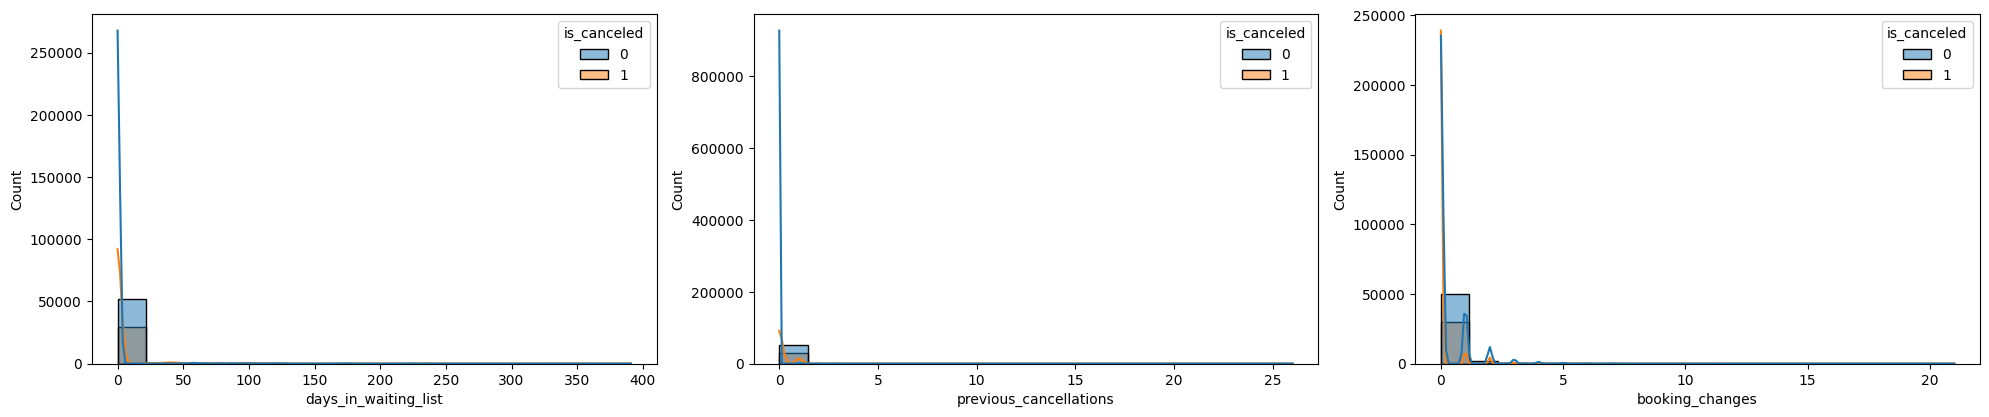

In [9]:
# Visualize histograms for numerical columns against cancellation status
columns_to_plot_numerical = ['days_in_waiting_list','previous_cancellations', 'booking_changes']

plt.figure(figsize=(20,12))
features = columns_to_plot_numerical
for i in range(0, len(features)):
    plt.subplot(3, 3, i+1)
    sns.histplot(x=df[features[i]], color='skyblue', hue=df['is_canceled'], kde=True)
    plt.xlabel(features[i])
    plt.tight_layout()

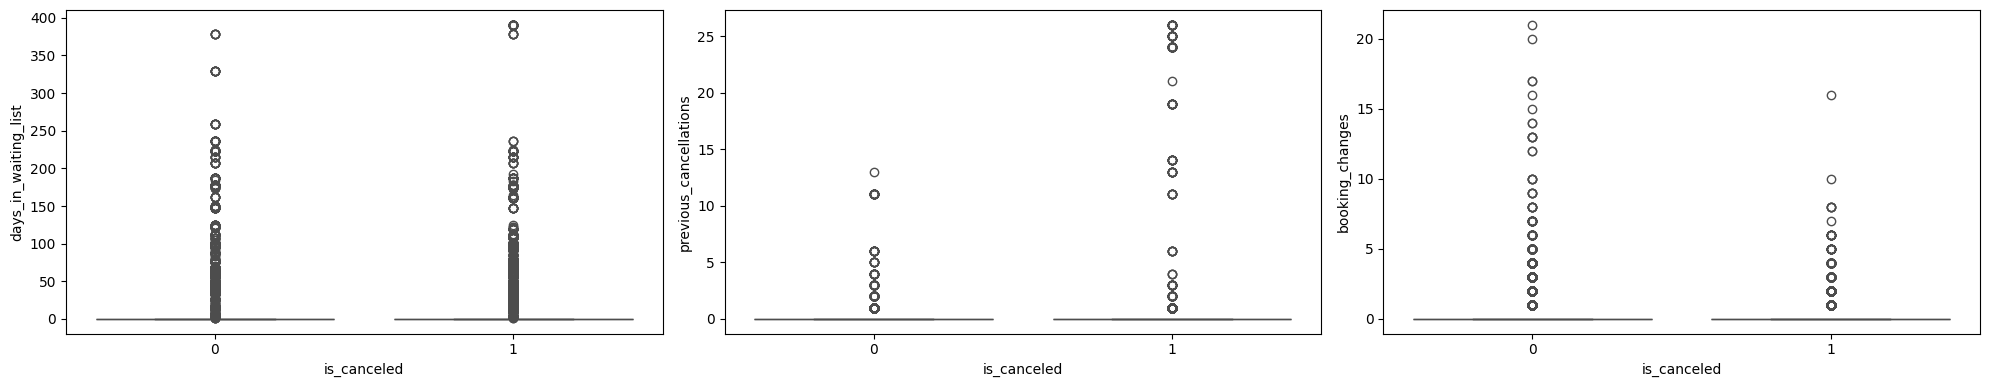

In [10]:
# visualize boxplots of numerical columns by cancellation status
plt.figure(figsize=(20,15))
features = columns_to_plot_numerical
for i in range(0, len(features)):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x = df['is_canceled'], y=df[features[i]], color='red')
    plt.tight_layout()

> ### **Insight** :
- higher `days_in_waiting_list` for customers who cancel, indicating that customers who have to wait longer to get their order confirmed are more likely to cancel their order.
- In the `booking_changes` column, it can be seen that customers who cancel their orders have lower average booking changes compared to customers who do not cancel. This could be because customers who do not cancel may make more frequent changes as they are still considering their options or have more dynamic needs.
- customers who have a high `cancelation history` are also likely to cancel their order again, and vice versa.

In [11]:
# get countries with highest cancellation cases
country_cancel = (df[df['is_canceled']==1]
                .groupby('country')
                .agg(func={'is_canceled':'count'})
                .reset_index()
                .sort_values(by='is_canceled', ascending=False))

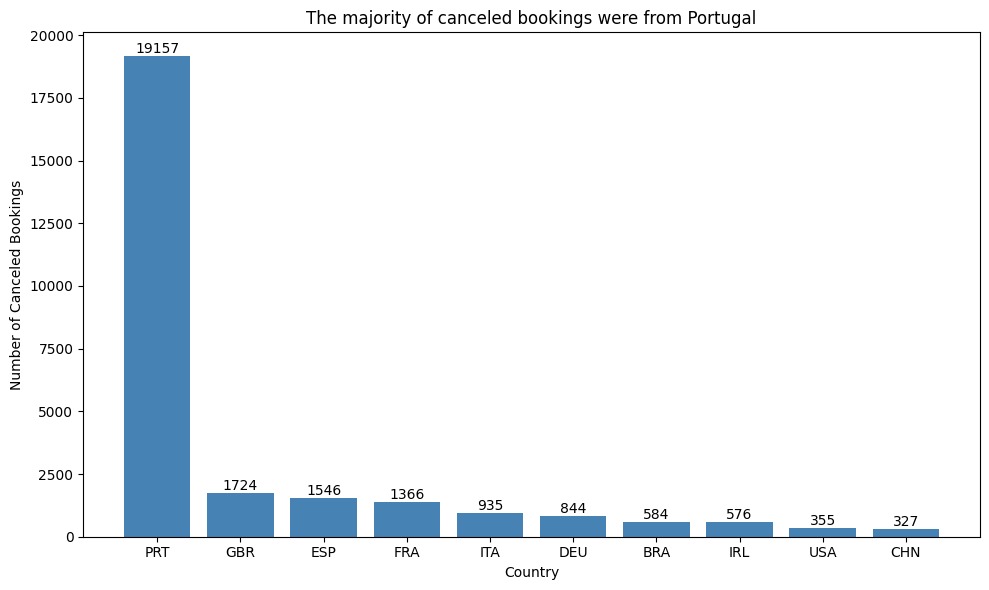

In [12]:
# create bar plot
plt.figure(figsize=(10, 6))
plt.bar(country_cancel['country'].head(10), 
        country_cancel['is_canceled'].head(10), 
        color='steelblue')

# add labels and title
plt.xlabel('Country')
plt.ylabel('Number of Canceled Bookings')
plt.title('The majority of canceled bookings were from Portugal')

# add labels to each bar
for i, value in enumerate(country_cancel['is_canceled'].head(10)):
    plt.text(i, value, str(value), ha='center', va='bottom')

# rotate x-axis labels
plt.xticks(rotation=0, ha='center')

# show plot
plt.tight_layout()
plt.show()

> ### **Insight** :
- Most guests who canceled the hotel bookings originated from Portugal (PRT) with 19157 cancellations. This indicates that customers from this country may have a signficant impact on the hotel's cancellation rate.
- While there is also a considerable variation in cancellation rates across country of origins, it is clear that European countries such as the UK (GBR), Spain (ESP), France (FRA), Italy (ITA), and Germany (DEU) have relatively high numbers of cancellations.

<a id="corelation_eda"></a>
# <b><span style='color:darkturquoise'>Step 4.4 |</span><span style='color:royalblue'> Correlation</span></b>

In [13]:
# check correlation: Numerical variables
(df.select_dtypes(include='number')
.corr(method='spearman')
.style.background_gradient(cmap='Blues')
.format('{:.2f}'))

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
previous_cancellations,1.00,-0.07,0.12,-0.04,-0.13,0.27
booking_changes,-0.07,1.00,-0.02,0.08,0.04,-0.18
days_in_waiting_list,0.12,-0.02,1.00,-0.04,-0.13,0.10
required_car_parking_spaces,-0.04,0.08,-0.04,1.00,0.09,-0.20
total_of_special_requests,-0.13,0.04,-0.13,0.09,1.00,-0.26
is_canceled,0.27,-0.18,0.10,-0.20,-0.26,1.00


In [14]:
# check correlation: categorical variables + is_canceled
import phik
(df.loc[:, ['country', 'market_segment', 'deposit_type', 'customer_type', 'reserved_room_type', 'is_canceled']]
.phik_matrix(interval_cols=['is_canceled'])
.style.background_gradient(cmap='Blues')
.format('{:.2f}'))

,country,market_segment,deposit_type,customer_type,reserved_room_type,is_canceled
country,1.00,0.45,0.55,0.24,0.24,0.44
market_segment,0.45,1.00,0.51,0.56,0.28,0.36
deposit_type,0.55,0.51,1.00,0.10,0.25,0.30
customer_type,0.24,0.56,0.10,1.00,0.18,0.20
reserved_room_type,0.24,0.28,0.25,0.18,1.00,0.10
is_canceled,0.44,0.36,0.30,0.20,0.10,1.00


<a id="preprocessing"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 5 | Data Preprocessing</p>

<a id="cleaning"></a>
# <b><span style='color:darkturquoise'>Step 5.1 |</span><span style='color:royalblue'> Identify Missing Value </span></b>

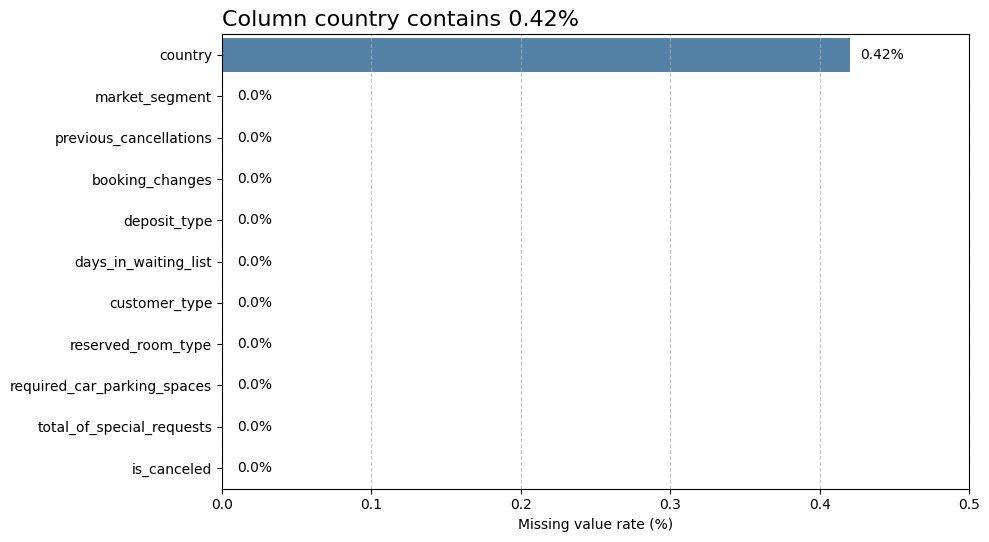

In [15]:
# identify missing value using graph
na_df = (df.isna().mean()*100).reset_index(name='percentage')
na_df['percentage'] = round(na_df['percentage'], 2)

plt.figure(figsize=(10, 6))

bar_plot = sns.barplot(
    data=na_df,
    y='index',
    x='percentage',
    color='steelblue',
    orient='h'
)

# Add text labels for each bar, closer to the bar end
for index, row in na_df.iterrows():
    bar_plot.text(row.percentage + 0.022, index, f'{row.percentage}%', color='black', ha="center", va="center")

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.ylabel('')
plt.xlabel('Missing value rate (%)')
plt.xticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.title('Column country contains 0.42%', loc='left', fontsize=16, color='black')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


> ### **Treatment** :
Based on our findings regarding the features of the dataset from the previous steps, there are a number of categorical features which, due to the large number of categories (high cardinality), probably do not have specific information for the model and should be considered as irrelevant features and should be deleted.  We will remove this feature for ease of work due to the large number of categories. However, one way to handle this, if needed in future work, is to group the countries into regions (e.g., North America, Europe, Asia, etc.) or to keep only the top N most frequent countries and group the rest into an 'Other' category.

In [16]:
# delete feature country
df = df.drop(['country'], axis=1)

<a id="duplicated"></a>
#<b><span style='color:darkturquoise'>Step 5.2 |</span><span style='color:royalblue'> Identify Duplicated Data </span></b>

In [17]:
# check duplicate rate
(df.duplicated().sum()/len(df)*100).round(2)

96.58

> ### **Insight** :
- The dataset shows a high duplicate rate of 96.58%, necessitating their removal as duplicates can significantly impact the classification model's performance. For example, the training set includes rows with identical values found in the test set. Consequently, when assessing the trained model with the test set, the model **memorizes** these values instead of **learning** general patterns, increasing the risk of overfitting.
- Overfitting generally occurs when a model encounters duplicate data points repeatedly. This causes the model to closely fit the training data without learning broader patterns. As a result, the model may perform poorly when applied to new, unseen data, despite achieving high accuracy on the training data.

In [18]:
df.duplicated().sum()

80714

In [19]:
# potential remaining data
len(df) - df.duplicated().sum()

2859

In [20]:
# handle duplicates
df.drop_duplicates(keep='first', inplace=True)

In [21]:
# double check duplicates
df.duplicated().sum()

0

In [22]:
# check length of dataset
len(df)

2859

<a id="noise"></a>
# <b><span style='color:darkturquoise'>Step 5.2 |</span><span style='color:royalblue'> Identify Outliers </span></b>

In [23]:
# separating numerical and categorical features
categorical_features = [
    'country',
    'deposite_type',
    'reserved_room_type',
    'market_segment',
    'customer_type'
]

numerical_features = [
    'previous_cancellations',
    'booking_changes',
    'days_in_waiting_list',
    'required_car_parking_spaces',
    'total_of_special_requests'
]

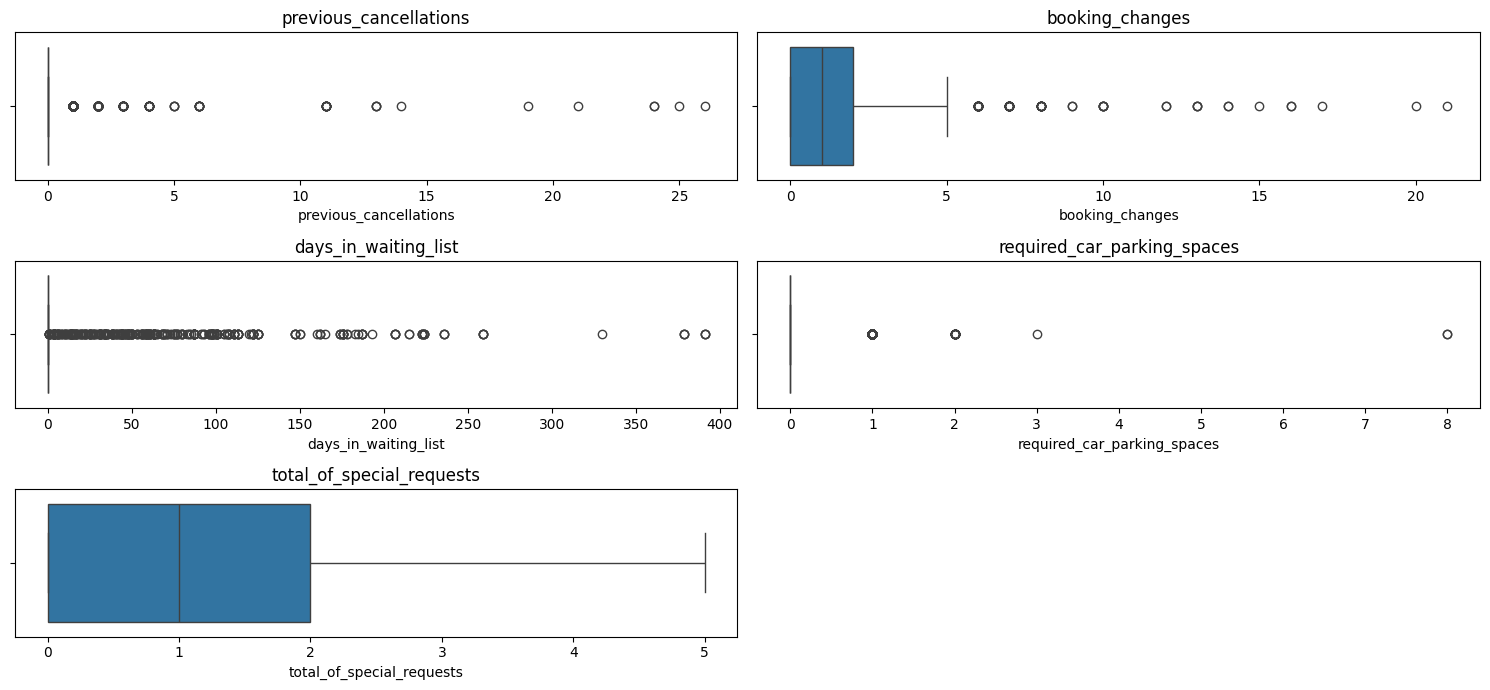

In [24]:
# define num cols
numerical_columns = df[['previous_cancellations', 'booking_changes', 
                        'days_in_waiting_list', 'required_car_parking_spaces', 
                        'total_of_special_requests']]

# setup up figure size
plt.figure(figsize=(15, 7))

# check outliers using boxplots
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'{col}')

plt.tight_layout()
plt.show()

In [25]:
# show outliers proportion for numerical column 
list_lower = []
list_upper = []
number_lower = []
number_inside = []
number_upper = []
percentage_outlier = []

for feature in numerical_features:
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    lower_bound = df[feature].quantile(0.25) - 1.5 * IQR
    upper_bound = df[feature].quantile(0.75) + 1.5 * IQR
    list_lower.append(lower_bound)
    list_upper.append(upper_bound)
    number_lower.append(len(df[df[feature] < lower_bound]))
    number_inside.append(len(df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]))
    number_upper.append(len(df[df[feature] > upper_bound]))
    percentage_outlier.append(round((len(df[df[feature] < lower_bound]) + len(df[df[feature] > upper_bound])) / len(df) * 100, 2))

outliers = pd.DataFrame({
    "Attribute (Numerical Features)" : numerical_features,
    "Lower Fence" : list_lower,
    "Upper Fence" : list_upper,
    "# Lower" : number_lower,
    "# Inside" : number_inside,
    "# Upper" : number_upper,
    "% Outlier" : percentage_outlier
})

outliers

,Attribute (Numerical Features),Lower Fence,Upper Fence,# Lower,# Inside,# Upper,% Outlier
0,previous_cancellations,0.0,0.0,0,2506,353,12.35
1,booking_changes,-3.0,5.0,0,2785,74,2.59
2,days_in_waiting_list,0.0,0.0,0,2470,389,13.61
3,required_car_parking_spaces,0.0,0.0,0,2270,589,20.60
4,total_of_special_requests,-3.0,5.0,0,2859,0,0.00


> ### **Insight** :
- The dataset analysis reveals varying levels of outliers across these numerical attributes related to hotel bookings. Attributes such as `booking_changes` and `previous_cancellations` exhibit higher outlier percentages, indicating potential areas of focus for understanding customer behavior and operational impacts.  As a consequence. to treat outliers we can use robust scaling :
- <b>Robust scaling</b>: This scaling technique convert numerical features into a similar range and is less sensitive to outliers since it uses median and interquartile range (IQR) in its formula. This technique will be particularly useful when the classification task is done by using distance-related models such as k-Nearest Neighbors, Logistic Regression, and Support Vector Machines

<a id="imbalance"></a>
# <b><span style='color:darkturquoise'>Step 5.3 |</span><span style='color:royalblue'> Unwanted Item Removal </span></b>

In [26]:
# check values in market segment
df['market_segment'].value_counts().reset_index(name='count')

,index,count
0,Online TA,844
1,Direct,598
2,Offline TA/TO,547
3,Groups,411
4,Corporate,270
5,Complementary,153
6,Aviation,35
7,Undefined,1


> The "Undefined" row has little impact on the analysis or machine learning model. This data is not useful because it does not represent a valid market segment. "Undefined" values can affect the model's accuracy and interpretation of results.

In [27]:
# drop undefined from the dataframe
df = df[df['market_segment'] != 'Undefined']

<a id="imbalance"></a>
# <b><span style='color:darkturquoise'>Step 5.4 |</span><span style='color:royalblue'> Check Imbalanced Data</span></b>

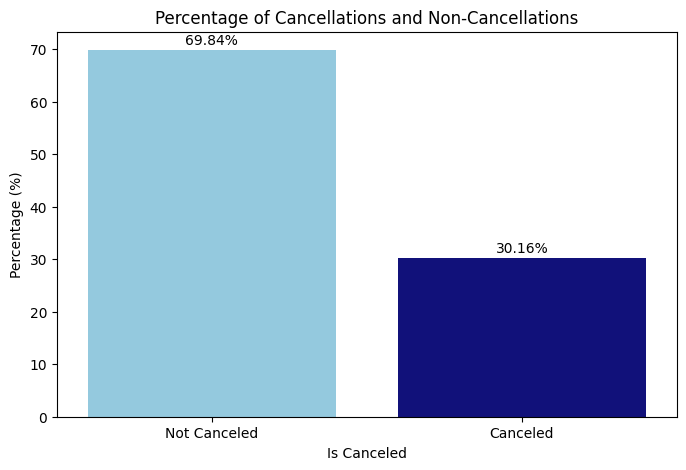

In [28]:
# Calculating the percentage of each class
percentage = df['is_canceled'].value_counts(normalize=True) * 100

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage, palette=['skyblue','darkblue'])
plt.title('Percentage of Cancellations and Non-Cancellations')
plt.xlabel('Is Canceled')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0,80,10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()

> ### **Insight** :
After applying duplicate removal earlier, the distribution of class (0: Not Canceled, 1: Canceled) remains uneven. The imbalanced issue will be subjected to a series of experiments to see which feature engineering techniques (e.g., NearMiss and SMOTE) is more superior in terms of handling the imbalance class problem in the target variable.

<a id="split"></a>
# <b><span style='color:darkturquoise'>Step 5.5 |</span><span style='color:royalblue'> Split the Dataset</span></b>

In [29]:
# define target feature and independent features
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

In [30]:
# splitting data into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=2023
)

> In the above split, we used __Stratification__ which ensures that the distribution of the target variable `is_canceled` is the same in both the train and test sets

<a id="encode"></a>
# <b><span style='color:darkturquoise'>Step 5.6 |</span><span style='color:royalblue'> Encode Categorical Variables</span></b>

After analyzing the dataset, we can categorize the features into three groups:

1. __No Encoding Needed__: These are the features that do not require any form of encoding because they are already in a numerical format that can be fed into a model.

    
2. __One-Hot Encoding__: This is required for nominal variables, which are categorical variables without any intrinsic order. One-hot encoding converts each unique value of the feature into a separate column with a 1 or 0, indicating the presence of that value. 

    
3. __Binary Encoding__: : This is an alternative to one-hot encoding and is used for categorical variables with many unique values. Binary encoding first converts the categories into integers and then converts those integers into binary code. Each binary digit is then a new feature. 

By categorizing the features into these groups, we can apply the appropriate encoding method to each feature, preparing the dataset for modeling.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2858 entries, 0 to 83227
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   market_segment               2858 non-null   object
 1   previous_cancellations       2858 non-null   int64 
 2   booking_changes              2858 non-null   int64 
 3   deposit_type                 2858 non-null   object
 4   days_in_waiting_list         2858 non-null   int64 
 5   customer_type                2858 non-null   object
 6   reserved_room_type           2858 non-null   object
 7   required_car_parking_spaces  2858 non-null   int64 
 8   total_of_special_requests    2858 non-null   int64 
 9   is_canceled                  2858 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 245.6+ KB


In [32]:
# Define the preprocessing steps
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), ['deposit_type', 'customer_type']),
    ('binary', ce.BinaryEncoder(), ['reserved_room_type', 'market_segment'])],
    remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['deposit_type', 'customer_type']),
                                ('binary', BinaryEncoder(),
                                 ['reserved_room_type', 'market_segment'])])

<a id="benchmark"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;"> Experiment 1 | Model Benchmark </p>


<a id="model_base"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Benchmark Model Definition </span></b>

In [33]:
# define model algoritm 
logreg = LogisticRegression(random_state=2023)
dtree = DecisionTreeClassifier(random_state=2023)
rf = RandomForestClassifier(random_state=2023)
xgb = XGBClassifier(random_state=2023)

models = [
    ('Logistic Regression', logreg),
    ('Decision Tree', dtree),
    ('Random Forest', rf),
    ('XGBoost', xgb)
]

In [34]:
#  define f2 score
f2_score = make_scorer(fbeta_score, beta=2)

<a id="base_eval"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Base Model Evaluation</span></b>

In [35]:
# define cross validate for benchmark model
def cross_validate_model(X_train, y_train, models):
    """
    This function performs cross-validation on a set of models, evaluates them using multiple metrics,
    and returns a DataFrame with the mean scores for accuracy, recall, precision, and F2 score.
    """
    list_name = []
    list_accuracy = []
    list_recall = []
    list_precision = []
    list_f2 = []
    list_f2_std = []

    for name, algorithm in models:
        pipe_model = Pipeline([
            ("preprocessing", preprocessor),
            ("algorithm", algorithm)
        ])
            
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

        # Gunakan parameter scoring yang diterima oleh fungsi
        model_cv = cross_validate(
            pipe_model,
            X_train,
            y_train,
            cv=skfold,
            scoring={
                    "accuracy": "accuracy",
                    "recall": "recall",
                    "precision": "precision",
                    "f2": f2_score,
                    },
            error_score="raise",
            n_jobs=-1
        )

        list_name.append(name)
        list_accuracy.append(round(model_cv["test_accuracy"].mean(), 3))
        list_recall.append(round(model_cv["test_recall"].mean(), 3))
        list_precision.append(round(model_cv["test_precision"].mean(), 3))
        list_f2.append(round(model_cv["test_f2"].mean(), 3))
        list_f2_std.append(round(model_cv["test_f2"].std(), 3))

    result = pd.DataFrame({
        "Model": list_name,
        "Mean Accuracy": list_accuracy,
        "Mean Recall": list_recall,
        "Mean Precision": list_precision,
        "Mean F2": list_f2,
        "Std F2": list_f2_std
    })

    return result.sort_values("Mean F2", ascending=False)

In [36]:
# define predict function for benchmark model
def predict_model(models, X_train, X_test, y_train, y_test):
    list_name = []
    list_accuracy_score = []
    list_recall_score = []
    list_precision_score = []
    list_f2_score = []
    
    for name, algorithm in models:
        pipe_model = Pipeline([
            ("preprocessing", preprocessor),
            ("algorithm", algorithm)
        ])

        pipe_model.fit(X_train, y_train)
        y_pred = pipe_model.predict(X_test)
        accuracy_scoring = accuracy_score(y_test,y_pred)
        recall_scoring = recall_score(y_test, y_pred)
        precision_scoring = precision_score(y_test, y_pred)
        f2_scoring = fbeta_score(y_test, y_pred, beta=2)  

        list_name.append(name)
        list_accuracy_score.append(round(accuracy_scoring,3))
        list_recall_score.append(round(recall_scoring, 3))
        list_precision_score.append(round(precision_scoring, 3))
        list_f2_score.append(round(f2_scoring, 3))
    
    result = pd.DataFrame({
        "Model": list_name,
        "Accuracy Score":list_accuracy_score,
        "Recall Score": list_recall_score,
        "Precision Score": list_precision_score,
        "F2 Score": list_f2_score
    })    

    return result.sort_values("F2 Score", ascending=False)

<a id="compare_base"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Comparing Train and Test Performance </span></b>

In [37]:
cross_validate_model(X_train, y_train, models)

,Model,Mean Accuracy,Mean Recall,Mean Precision,Mean F2,Std F2
3,XGBoost,0.725,0.453,0.556,0.470,0.015
2,Random Forest,0.670,0.415,0.450,0.421,0.021
0,Logistic Regression,0.761,0.382,0.688,0.419,0.026
1,Decision Tree,0.654,0.411,0.425,0.413,0.022


> From the cross validation results above, it can be seen that the XGBoost and Random Forest models have good performance when viewed from the average F2 score value.

In [38]:
predict_model(models, X_train, X_test, y_train, y_test)

,Model,Accuracy Score,Recall Score,Precision Score,F2 Score
3,XGBoost,0.738,0.468,0.583,0.487
2,Random Forest,0.650,0.393,0.417,0.398
0,Logistic Regression,0.741,0.358,0.626,0.392
1,Decision Tree,0.645,0.364,0.404,0.371


> XGBoost and Random Forest show robust performance across recall and F2 score metrics, indicating their suitability for scenarios where identifying canceled bookings is crucial.

> ### **Insight** :
- Experiment 1 puts XGBoost as the highest performing model with $F_2$=0.470. To note, this is the original model which neither uses scaling technique yet to minimize the output of the outliers in some numerical features. These feature engineering technique will be tested in the following experiment.

<a id="scaler"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;"> Experiment 2 | Scaler </p>

<a id="scaler_eval"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Base Model With Scaling Evaluation</span></b>

In [39]:
# define cross validate for benchmark model
def cross_validate_model_scaler(X_train, y_train, models):
    """
    This function performs cross-validation on a set of models, evaluates them using multiple metrics,
    and returns a DataFrame with the mean scores for accuracy, recall, precision, and F2 score.
    """
    list_name = []
    list_accuracy = []
    list_recall = []
    list_precision = []
    list_f2 = []
    list_f2_std = []

    scaler = RobustScaler()

    for name, algorithm in models:
        pipe_model = Pipeline([
            ("preprocessing", preprocessor),
            ("scaler", scaler),
            ("algorithm", algorithm)
        ])
            
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

        # Gunakan parameter scoring yang diterima oleh fungsi
        model_cv = cross_validate(
            pipe_model,
            X_train,
            y_train,
            cv=skfold,
            scoring={
                    "accuracy": "accuracy",
                    "recall": "recall",
                    "precision": "precision",
                    "f2": f2_score
                    },
            error_score="raise",
            n_jobs=-1
        )

        list_name.append(name)
        list_accuracy.append(round(model_cv["test_accuracy"].mean(), 3))
        list_recall.append(round(model_cv["test_recall"].mean(), 3))
        list_precision.append(round(model_cv["test_precision"].mean(), 3))
        list_f2.append(round(model_cv["test_f2"].mean(), 3))
        list_f2_std.append(round(model_cv["test_f2"].std(), 3))

    result = pd.DataFrame({
        "Model": list_name,
        "Mean Accuracy": list_accuracy,
        "Mean Recall": list_recall,
        "Mean Precision": list_precision,
        "Mean F2": list_f2,
        "Std F2":list_f2_std
    })

    return result.sort_values("Mean F2", ascending=False)

In [40]:
# define predict function for benchmark model
def predict_model_scaler(models, X_train, X_test, y_train, y_test):
    list_name = []
    list_accuracy_score = []
    list_recall_score = []
    list_precision_score = []
    list_f2_score = []

    scaler = RobustScaler()

    for name, algorithm in models:
        pipe_model = Pipeline([
            ("preprocessing", preprocessor),
            ("scaler",scaler),
            ("algorithm", algorithm)
        ])

        pipe_model.fit(X_train, y_train)
        y_pred = pipe_model.predict(X_test)
        accuracy_scoring = accuracy_score(y_test,y_pred)
        recall_scoring = recall_score(y_test, y_pred)
        precision_scoring = precision_score(y_test, y_pred)
        f2_scoring = fbeta_score(y_test, y_pred, beta=2)  

        list_name.append(name)
        list_accuracy_score.append(round(accuracy_scoring,3))
        list_recall_score.append(round(recall_scoring, 3))
        list_precision_score.append(round(precision_scoring, 3))
        list_f2_score.append(round(f2_scoring, 3))
    
    result = pd.DataFrame({
        "Model": list_name,
        "Accuracy Score":list_accuracy_score,
        "Recall Score": list_recall_score,
        "Precision Score": list_precision_score,
        "F2 Score": list_f2_score
    })    

    return result.sort_values("F2 Score", ascending=False)

<a id="compare_scaling"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Comparing Train and Test Performance (Scaling) </span></b>

In [41]:
cross_validate_model_scaler(X_train, y_train, models)

,Model,Mean Accuracy,Mean Recall,Mean Precision,Mean F2,Std F2
3,XGBoost,0.725,0.453,0.556,0.470,0.015
0,Logistic Regression,0.763,0.385,0.696,0.422,0.026
2,Random Forest,0.670,0.415,0.450,0.421,0.021
1,Decision Tree,0.654,0.411,0.425,0.413,0.022


In [42]:
predict_model_scaler(models, X_train, X_test, y_train, y_test)

,Model,Accuracy Score,Recall Score,Precision Score,F2 Score
3,XGBoost,0.738,0.468,0.583,0.487
2,Random Forest,0.650,0.393,0.417,0.398
0,Logistic Regression,0.745,0.358,0.639,0.393
1,Decision Tree,0.645,0.364,0.404,0.371


> ### **Insight** :
After applying scaling, the F2 scores of 3 out of 4 models remained unchanged. Only the Logistic Regression model showed an improvement, with its F2 score increasing to 0.422. The highest F2 score is still held by the XGBoost model.

<a id="resampler"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;"> Experiment 3 | Resampler </p>

<a id="define_param"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Define Resampling Techniques</span></b>

In [43]:
# determine the resampler method that will be compared in performance
smote = SMOTE(random_state = 42)
nearmiss = NearMiss()

<a id="resampler"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Model With Resamplers Evaluation </span></b>

In [44]:
# Define custom F2 score and wrap it with make_scorer
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

f2_scorer = make_scorer(f2_score)

# define cross validate function use resamplers method
def cross_validate_with_sampling(X_train, y_train, models, resampler):
    list_name = []
    list_recall = []
    list_precision = []
    list_f2 = []
    list_f2_std = []

    for name, algorithm in models:
        pipe_model = Pipeline([
                ("preprocessing", preprocessor),
                ("resampler", resampler),
                ("algorithm", algorithm)
            ])
            
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

        model_cv = cross_validate(
            estimator=pipe_model,
            X=X_train,
            y=y_train,
            cv=skfold,
            scoring={
                "accuracy": "accuracy",
                "recall": "recall",
                "precision": "precision",
                "f2": f2_scorer
            },
            error_score="raise",
            n_jobs=-1
        )

        list_name.append(name)
        list_recall.append(round(model_cv["test_recall"].mean(), 3))
        list_precision.append(round(model_cv["test_precision"].mean(), 3))
        list_f2.append(round(model_cv["test_f2"].mean(), 3))
        list_f2_std.append(round(model_cv["test_f2"].std(),3))

    if resampler == smote:
        sampling = "SMOTE"
    elif resampler == nearmiss:
        sampling = "NearMiss"

    result = pd.DataFrame({
        f"Model - {sampling}": list_name,
        "Mean Recall": list_recall,
        "Mean Precision": list_precision,
        "Mean F2": list_f2,
        "Std F2" : list_f2_std
    })

    return result.sort_values("Mean F2", ascending=False)

In [45]:
# Define custom F2 score
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# define predict function using resamplers method
def predict_with_sampling(models, resampler):
    list_name = []
    list_recall_score = []
    list_precision_score = []
    list_f2_score = []

    for name, algorithm in models:
        pipe_model = Pipeline([
                ("preprocessing", preprocessor),
                ("resampler", resampler),
                ("algorithm", algorithm)
            ])

        pipe_model.fit(X_train, y_train)
        y_pred = pipe_model.predict(X_test)
        recall_scoring = recall_score(y_test, y_pred)
        precision_scoring = precision_score(y_test, y_pred)
        f2_scoring = f2_score(y_test, y_pred)

        list_name.append(name)
        list_recall_score.append(round(recall_scoring, 3))
        list_precision_score.append(round(precision_scoring, 3))
        list_f2_score.append(round(f2_scoring, 3))
    
    if resampler == smote:
        sampling = "SMOTE"
    elif resampler == nearmiss:
        sampling = "NearMiss"
    
    result = pd.DataFrame({
        f"Model - {sampling}": list_name,
        "Recall Score": list_recall_score,
        "Precision Score": list_precision_score,
        "F2 Score": list_f2_score
    })

    return result.sort_values("Recall Score", ascending=False)

<a id="smote"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> SMOTE </span></b>

In [46]:
# menampilkan hasil benchmark model menggunakan SMOTE
cross_validate_with_sampling(X_train, y_train, models, smote)

,Model - SMOTE,Mean Recall,Mean Precision,Mean F2,Std F2
0,Logistic Regression,0.761,0.511,0.693,0.017
3,XGBoost,0.467,0.531,0.478,0.028
2,Random Forest,0.435,0.448,0.437,0.034
1,Decision Tree,0.401,0.414,0.403,0.010


In [47]:
# menampilkan hasil predict to test set menggunakan SMOTE
predict_with_sampling(models, smote)

,Model - SMOTE,Recall Score,Precision Score,F2 Score
0,Logistic Regression,0.769,0.504,0.696
3,XGBoost,0.480,0.568,0.495
2,Random Forest,0.422,0.422,0.422
1,Decision Tree,0.370,0.379,0.372


> ### **Insight** :
After applying resampling techniques, specifically SMOTE, Logistic Regression took the top position followed by XGBoost in second place. There was a decrease in the average F2 score of XGBoost when using SMOTE.

<a id="nearmiss"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Near Miss </span></b>

In [48]:
# menampilkan hasil benchmark model menggunakan SMOTE
cross_validate_with_sampling(X_train, y_train, models, nearmiss)

,Model - NearMiss,Mean Recall,Mean Precision,Mean F2,Std F2
0,Logistic Regression,0.557,0.522,0.549,0.037
3,XGBoost,0.553,0.411,0.517,0.027
2,Random Forest,0.517,0.361,0.475,0.041
1,Decision Tree,0.469,0.357,0.441,0.053


In [49]:
# menampilkan hasil predict to test set menggunakan SMOTE
predict_with_sampling(models, nearmiss)

,Model - NearMiss,Recall Score,Precision Score,F2 Score
3,XGBoost,0.497,0.422,0.480
2,Random Forest,0.462,0.338,0.431
0,Logistic Regression,0.451,0.453,0.451
1,Decision Tree,0.416,0.320,0.393


> ### **Insight** :
Using the NearMiss resampling method, Logistic Regression still took the top position followed by XGBoost in second place. However, there was a slight decrease in its average F2 score.

<a id="hyperparam"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;"> Experiment 4 | Hyperparameter Tuning </p>

> In the following step, all of the model will be tuned using custom grid (`param_grid`). The parameter controls the amount of variance added to each feature's variance to prevent overfitting. 

<a id="tuning"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Model With Resamplers and Tuning Evaluation </span></b>

In [50]:
# Define custom F2 score and wrap it with make_scorer
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

f2_scorer = make_scorer(f2_score)

def tune_clf_hyperparameters(clf, param_grid, X_train, y_train):
    """
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest F2-score for class 1 (canceled bookings) is selected as the default scoring metric. 
    The function returns a DataFrame summarizing the results of the hyperparameter tuning.
    """

    resampler = SMOTE(random_state=42)
    scaler = RobustScaler()

    # Create the pipeline
    pipe_model = Pipeline([
        ("preprocessing", preprocessor),
        ("scaler", scaler),
        ("resampler", resampler),
        ("algorithm", clf)
    ])

    # Define the cross-validation strategy with random_state
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state= 2020)

    # Perform GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipe_model,
        param_grid=param_grid,
        scoring=f2_scorer,
        cv=cv,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    # Retrieve best parameters
    best_params = grid_search.best_params_

    return grid_search.best_estimator_, best_params

In [51]:
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
def f2_score(y_true, y_pred, pos_label=1):
    '''
    This function calculates the F2 score, which is the weighted harmonic mean of precision and recall,
    with more weight given to recall.
    '''
    return fbeta_score(y_true, y_pred, beta=2, pos_label=pos_label)

def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    The metrics are calculated specifically for class 1. 
    '''
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    result = pd.DataFrame(data=[[accuracy_score(y_test, y_pred)],
                                [precision_score(y_test, y_pred, pos_label=1)],
                                [recall_score(y_test, y_pred, pos_label=1)],
                                [f2_score(y_test, y_pred, pos_label=1)],
                                [average_precision_score(y_test, y_proba)]],
                        index=['Accuracy', 'Precision (Class 1)', 'Recall (Class 1)', 'F2-score (Class 1)', 'PR AUC (Class 1)'],
                        columns=[model_name])
    
    result = (result * 100).round(2).astype(str) + '%'
    return result

In [52]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and Precision-Recall curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Calculate predicted probabilities for class 1
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot Precision-Recall curve for test data and display PR AUC score 
    precision, recall, _ = precision_recall_curve(y_test, y_proba, pos_label=1)
    pr_auc = average_precision_score(y_test, y_proba)
    
    ax2.plot(recall, precision, color='royalblue', lw=2)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'Precision-Recall Curve for Test Data\nPR AUC: {pr_auc:.2f}')
    ax2.grid(True)
    
    # Report results for the test data
    result_test = metrics_calculator(clf, X_test, y_test, model_name)
    table_test = ax3.table(cellText=result_test.values, colLabels=result_test.columns, rowLabels=result_test.index, loc='center')
    table_test.scale(0.6, 2)
    table_test.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table_test.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')

    plt.tight_layout()
    plt.show()

<a id="xgboost"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> XGBoost </span></b>

In [53]:
# Define the parameter grid
param_grid_xgb = {
    'algorithm__n_estimators': [250, 350],
    'algorithm__learning_rate': [0.01, 0.1],
    'algorithm__max_depth': [7, 8],
    'algorithm__subsample': [0.7, 0.8],
    'algorithm__colsample_bytree': [0.8, 0.9],
    'algorithm__scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()],
}

In [54]:
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(xgb, param_grid_xgb, X_train, y_train)
print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)

XGBoost Optimal Hyperparameters: 
 {'algorithm__colsample_bytree': 0.9, 'algorithm__learning_rate': 0.01, 'algorithm__max_depth': 7, 'algorithm__n_estimators': 250, 'algorithm__scale_pos_weight': 2.3178519593613935, 'algorithm__subsample': 0.8}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.61      0.75      1597
           1       0.51      0.95      0.67       689

    accuracy                           0.71      2286
   macro avg       0.74      0.78      0.71      2286
weighted avg       0.83      0.71      0.72      2286


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.56      0.70       399
           1       0.47      0.91      0.62       173

    accuracy                           0.66       572
   macro avg       0.70      0.73      0.66       572
weighted avg       0.79      0.66      0.68       572



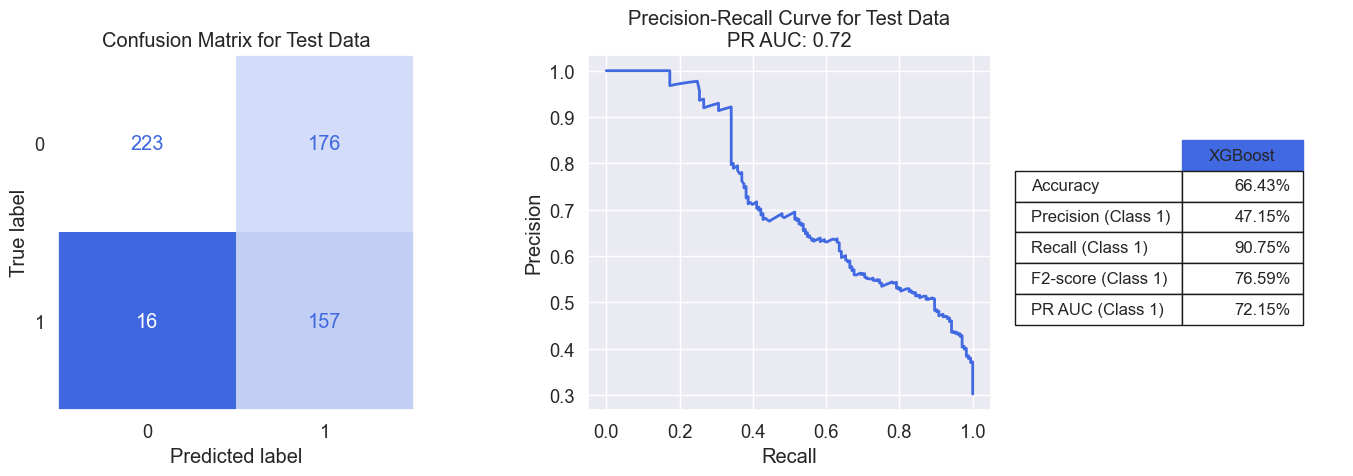

In [55]:
model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost')

<a id="dtree"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Decision Tree </span></b>

In [56]:
# Define the hyperparameter grid for Decision Tree
param_grid_dt = {
    'algorithm__criterion': ['gini', 'entropy'],
    'algorithm__max_depth': [13, 14, 15],
    'algorithm__min_samples_split': [2, 3, 4],
    'algorithm__min_samples_leaf': [1, 2, 3],
    'algorithm__class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

In [57]:
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dtree, param_grid_dt, X_train, y_train)
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'algorithm__class_weight': {0: 1, 1: 3}, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 13, 'algorithm__min_samples_leaf': 3, 'algorithm__min_samples_split': 2}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.66      0.78      1597
           1       0.54      0.95      0.69       689

    accuracy                           0.74      2286
   macro avg       0.76      0.80      0.74      2286
weighted avg       0.84      0.74      0.75      2286


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.57      0.70       399
           1       0.46      0.84      0.59       173

    accuracy                           0.65       572
   macro avg       0.67      0.70      0.64       572
weighted avg       0.76      0.65      0.66       572



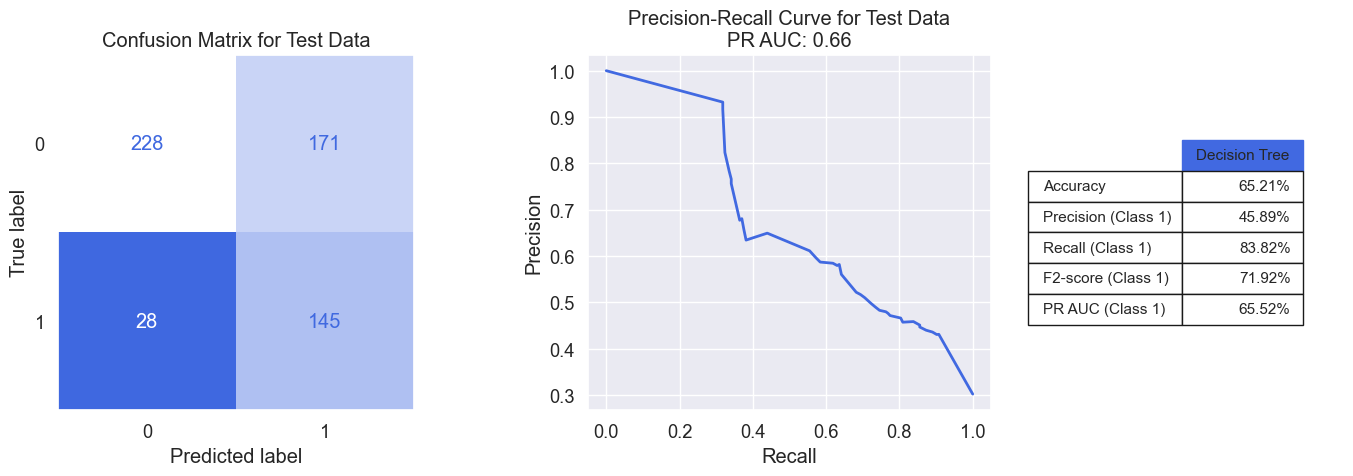

In [58]:
model_evaluation(best_dt, X_train, X_test, y_train, y_test, 'Decision Tree')

<a id="randfor"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Random Forest </span></b>

In [59]:
# Contoh penggunaan fungsi dengan model dan grid search untuk Random Forest
param_grid_rf = {
    'algorithm__n_estimators': [100, 150],
    'algorithm__criterion': ['entropy'],
    'algorithm__max_depth': [15, 16],
    'algorithm__min_samples_split': [2, 3, 4, 5],
    'algorithm__min_samples_leaf': [1, 2, 3],
    'algorithm__class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

In [60]:
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf, param_grid_rf, X_train, y_train)
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'algorithm__class_weight': {0: 1, 1: 3}, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 15, 'algorithm__min_samples_leaf': 3, 'algorithm__min_samples_split': 2, 'algorithm__n_estimators': 150}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.64      0.78      1597
           1       0.54      0.97      0.69       689

    accuracy                           0.74      2286
   macro avg       0.76      0.80      0.73      2286
weighted avg       0.84      0.74      0.75      2286


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.57      0.70       399
           1       0.47      0.87      0.61       173

    accuracy                           0.66       572
   macro avg       0.69      0.72      0.65       572
weighted avg       0.78      0.66      0.67       572



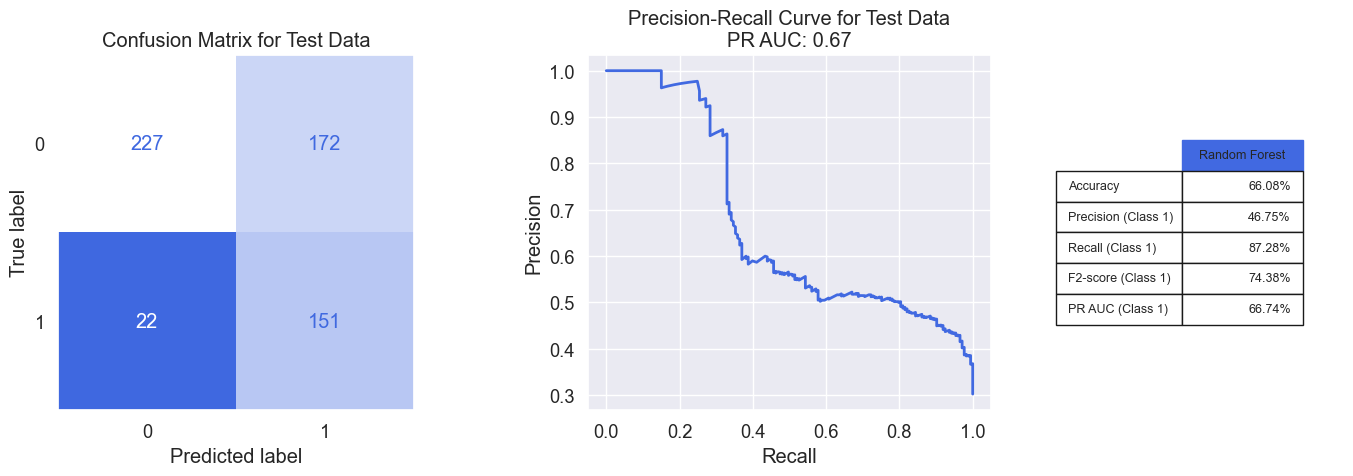

In [61]:
model_evaluation(best_rf, X_train, X_test, y_train, y_test, 'Random Forest')

<a id="logreg"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Logistic Regression </span></b>

In [62]:
param_grid_logreg = {
    'algorithm__C': [0.01, 0.1, 1, 10, 100],
    'algorithm__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'algorithm__solver': ['liblinear', 'saga'],
    'algorithm__class_weight': ['balanced', None],
    'algorithm__max_iter': [100, 200, 300]
}

In [63]:
best_logreg, best_logreg_hyperparams = tune_clf_hyperparameters(logreg, param_grid_logreg, X_train, y_train)
print('Logreg Optimal Hyperparameters: \n', best_logreg_hyperparams)

Logreg Optimal Hyperparameters: 
 {'algorithm__C': 1, 'algorithm__class_weight': 'balanced', 'algorithm__max_iter': 100, 'algorithm__penalty': 'l1', 'algorithm__solver': 'liblinear'}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1597
           1       0.53      0.78      0.63       689

    accuracy                           0.72      2286
   macro avg       0.70      0.74      0.70      2286
weighted avg       0.77      0.72      0.73      2286


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.67      0.75       399
           1       0.50      0.75      0.60       173

    accuracy                           0.69       572
   macro avg       0.68      0.71      0.68       572
weighted avg       0.75      0.69      0.71       572



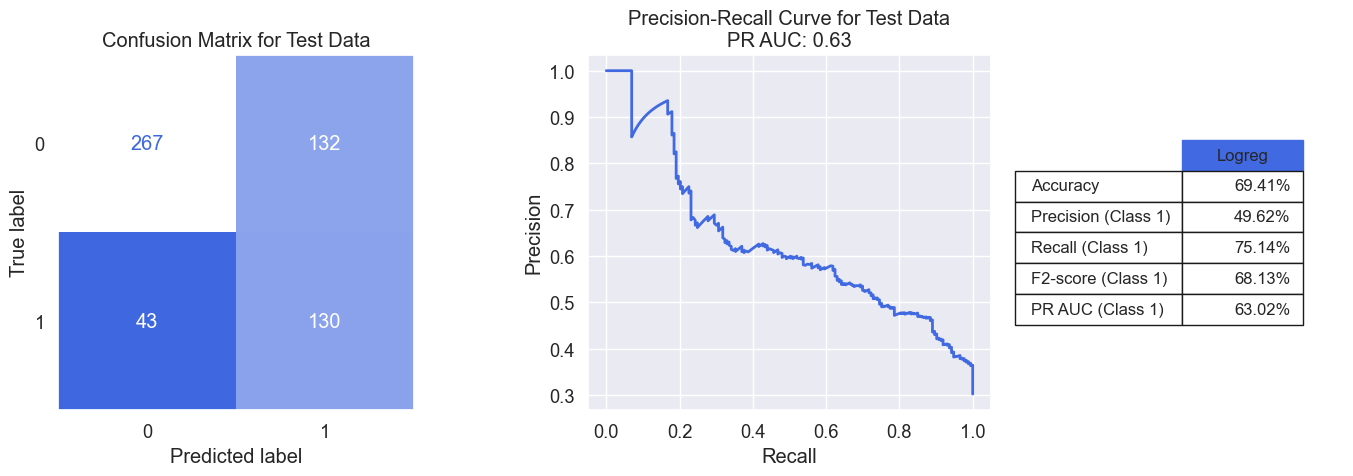

In [64]:
# Example usage
model_evaluation(best_logreg, X_train, X_test, y_train, y_test, 'Logreg')

<a id="modelsel"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;"> Model Selection </p>

<a id="selection"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Model Selection </span></b>

> After running 4 experiments to predict hotel booking cancellations, I found that the XGBoost model from the 4th experiment gave the best performance. This experiment showed the most accurate results with an F2-score of 0.76, recall of 0.90, and precision of 0.47 in predicting cancelations. This experiment also utilizes the SMOTE (Synthetic Minority Over-sampling Technique) resampling technique which helps to overcome data imbalance. With the good optimization of the model parameters and the use of SMOTE, I decided to use the XGBoost model from the 4th experiment as the final model for further analysis and implementation in the hotel prediction system.

<a id="confusion_matrix"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Confusion Matrix Comparison </span></b>


In [65]:
# predict use benchmark model 
def before_after(model):
    model_pipe = Pipeline([
        ('transformer', preprocessor),
        ('model', model)
    ])
    model_pipe.fit(X_train, y_train)
    y_pred_before = model_pipe.predict(X_test)
    return y_pred_before

In [66]:
# predict use best model
y_pred_before_xgb = before_after(xgb)
y_pred_after_xgb = best_xgb.predict(X_test)

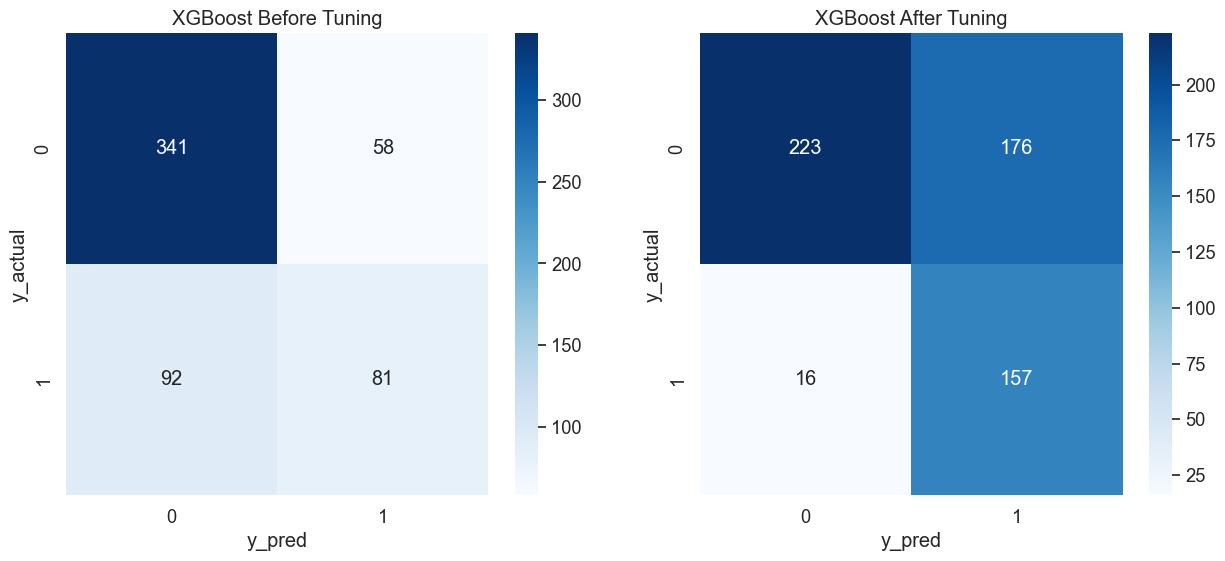

In [67]:
# show confusion matrix before and after tuning
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test,y_pred_before_xgb),annot=True,fmt='.0f', cmap='Blues')
plt.xlabel('y_pred')
plt.ylabel('y_actual')
plt.title('XGBoost Before Tuning')
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test,y_pred_after_xgb),annot=True,fmt='.0f', cmap='Blues')
plt.xlabel('y_pred')
plt.ylabel('y_actual')
plt.title('XGBoost After Tuning')
plt.show()

In [68]:
def f2_score(y_true, y_pred, pos_label=1):
    '''
    This function calculates the F2 score, which is the weighted harmonic mean of precision and recall,
    with more weight given to recall.
    '''
    return fbeta_score(y_true, y_pred, beta=2, pos_label=pos_label)


def model_evaluation_compare(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    # Calculate metrics for training set
    metrics_train = metrics_calculator(clf, X_train, y_train, model_name)
    metrics_train.columns = ['Training']

    # Calculate metrics for test set
    metrics_test = metrics_calculator(clf, X_test, y_test, model_name)
    metrics_test.columns = ['Test']

    # Combine training and test metrics
    metrics_combined = pd.concat([metrics_train, metrics_test], axis=1)
    
    # Display metrics
    print(metrics_combined)
    

model_evaluation_compare(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost')

                    Training    Test
Accuracy             71.35%   66.43%
Precision (Class 1)  51.33%   47.15%
Recall (Class 1)     94.92%   90.75%
F2-score (Class 1)   81.14%   76.59%
PR AUC (Class 1)     78.2%    72.15%


<a id="explain"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;"> Explainable AI </p>

<a id="featureimp"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Feature Important </span></b>

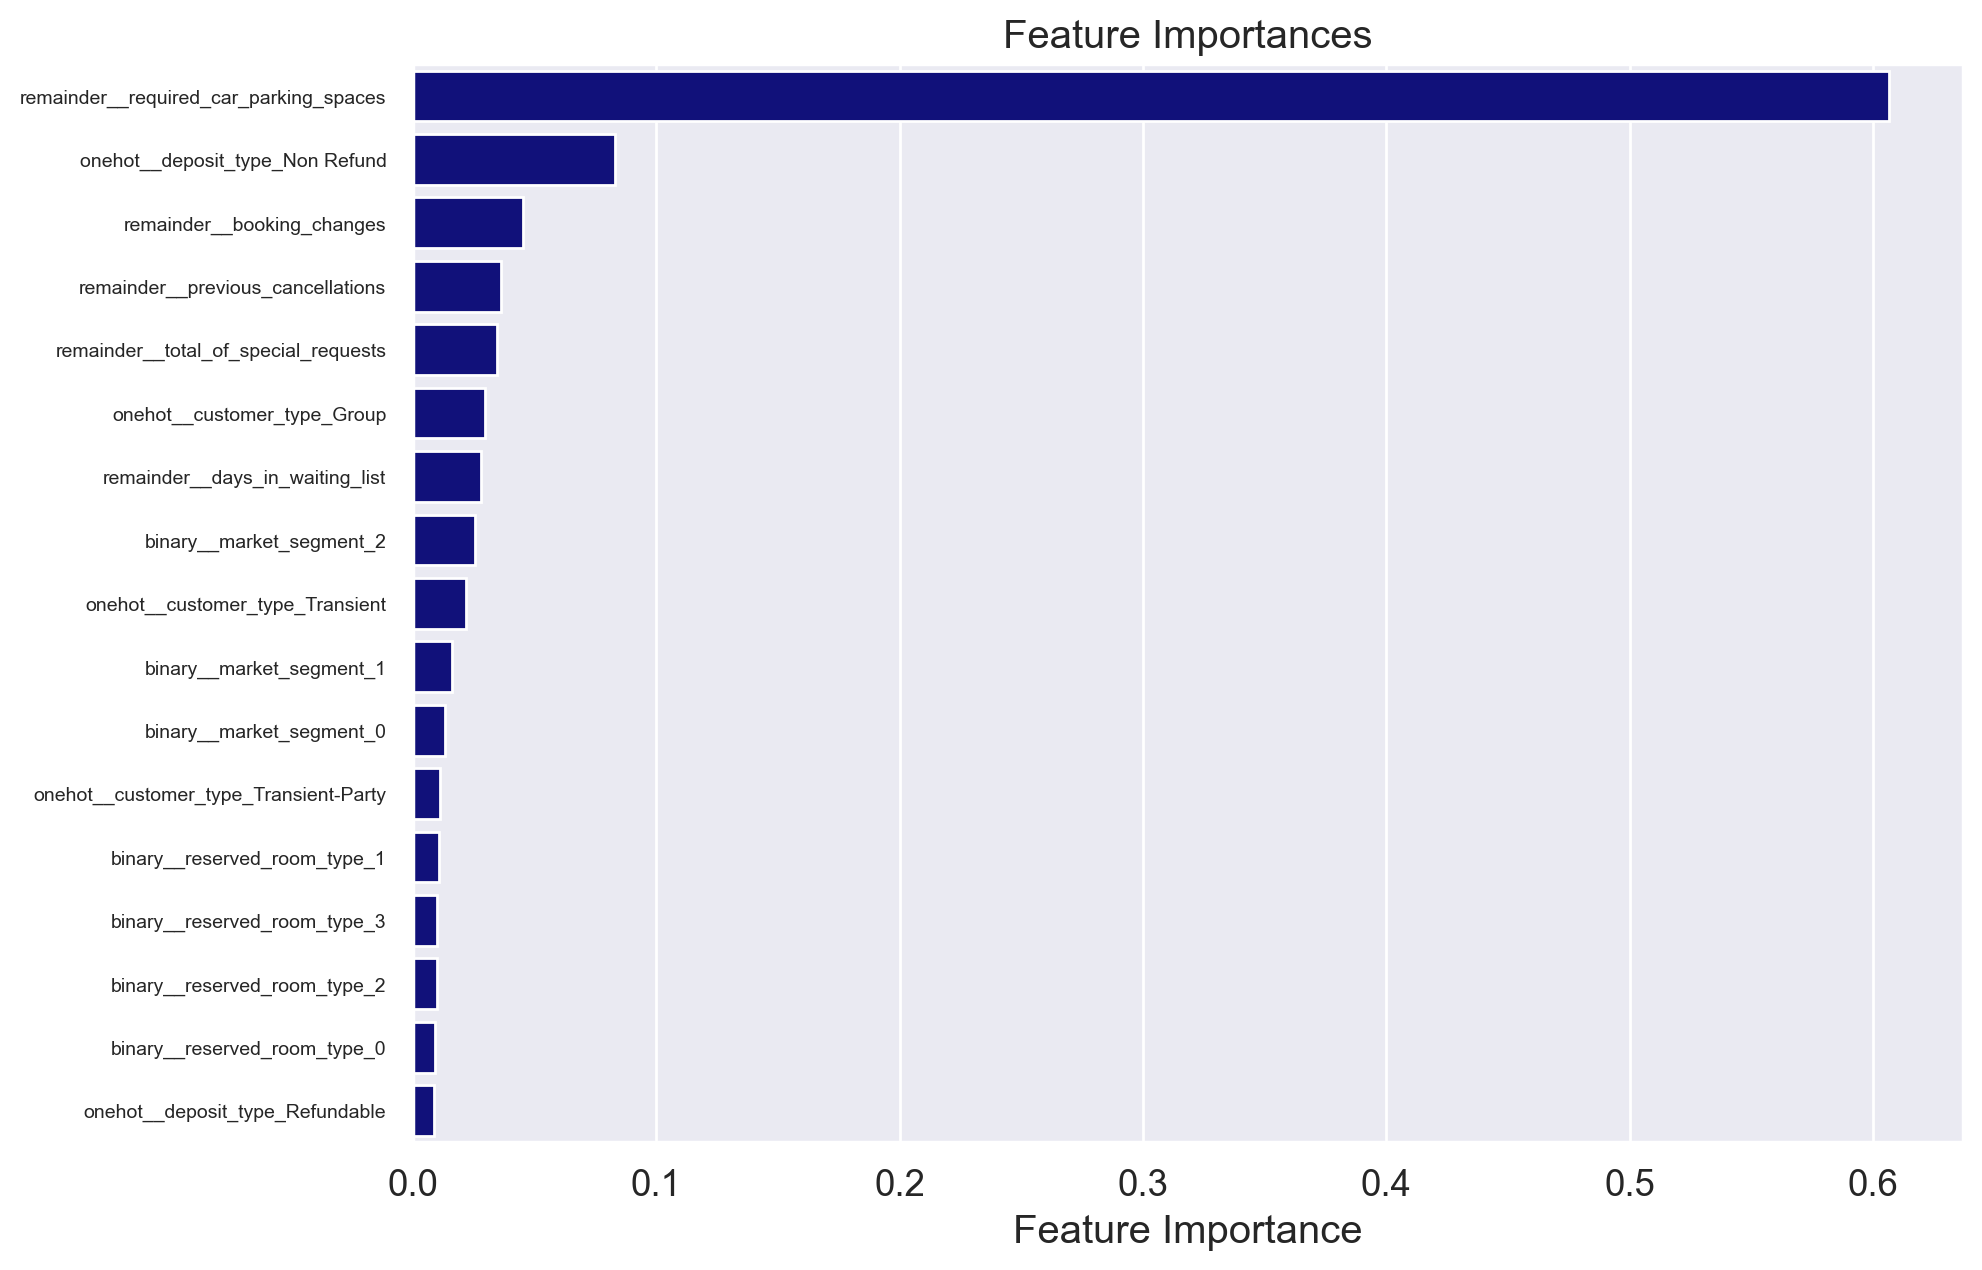

In [69]:
# Access the Decision Tree model from within the pipeline
best_xgb_model = best_xgb.named_steps['algorithm']

# Get the feature importances from the model
feature_importances = best_xgb_model.feature_importances_

# Get the feature names after preprocessing
preprocessor = best_xgb.named_steps['preprocessing']
feature_names = preprocessor.get_feature_names_out()

# Sort feature importances in descending order and get the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 7), dpi=200)
sns.barplot(x=feature_importances[sorted_indices], y=np.array(feature_names)[sorted_indices], color='darkblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.yticks(fontsize=7)
plt.show()

> ### **Insight** :

Feature importance analysis assesses the relative influence of each feature on a model's predictions. In this case, `required_car_parking_spaces` emerges as the most significant feature, indicating it has the strongest predictive power regarding booking cancellations.

<a id="shap"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> SHAP </span></b>

In [70]:
features = list(best_xgb.named_steps['preprocessing'].get_feature_names_out())
list_features = []
for feat in features:
    list_features.append('_'.join(feat.split('_')[2:]))
list_features

['deposit_type_Non Refund',
 'deposit_type_Refundable',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'reserved_room_type_0',
 'reserved_room_type_1',
 'reserved_room_type_2',
 'reserved_room_type_3',
 'market_segment_0',
 'market_segment_1',
 'market_segment_2',
 'previous_cancellations',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests']

PermutationExplainer explainer: 573it [00:56,  8.86it/s]                         


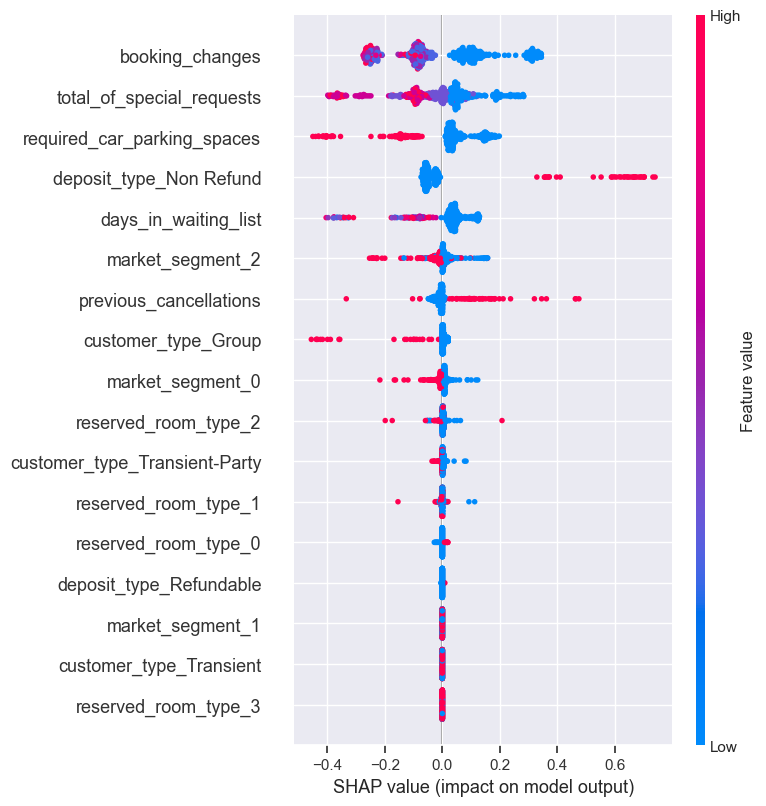

In [71]:
# Fit the best model on the training data (assuming best_xgb is your trained model)
best_xgb.fit(X_train, y_train)

# Transform the training data using the pipeline
X_train_transformed = pd.DataFrame(
    best_xgb.named_steps['preprocessing'].transform(X_train),
    columns=list_features
)

# Transform the test data using the pipeline
X_test_transformed = pd.DataFrame(
    best_xgb.named_steps['preprocessing'].transform(X_test),
    columns=list_features
)

# Access the decision tree model from within the pipeline
best_xgb_model = best_xgb.named_steps['algorithm']

# Create an object that can calculate SHAP values using PermutationExplainer
explainer = shap.Explainer(best_xgb_model.predict, X_train_transformed, algorithm="permutation")

# Calculate SHAP values for test data
shap_values = explainer(X_test_transformed)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_transformed)


> SHAP value: This shows how each feature affects the model's predictions. A positive value means the feature increases the probability of cancellation, while a negative value means it decreases it. The colour indicates the value of the feature. Red has a high value, while blue has a low value.

> ### **Insight** :
- `required_car_parking_spaces`: The more parking spaces required, the greater the chance of cancellation.
- `booking_changes`: Booking changes can increase or decrease the likelihood of cancellation depending on the number of changes.
- `total_of_special_requests`: A high number of special requests tends to decrease the likelihood of cancellation.
- `market_segment_2`: Certain market segments increase the likelihood of cancellation.
- `deposit_type_Non Refund`: A non-refundable deposit type increases the likelihood of cancellation.
- `previous_cancellations`: More previous cancellations increase the likelihood of cancellation.
- `reserved_room_type_1 and 2`: These room types tend to reduce the likelihood of cancellation.
- `customer_type_Group` and `Transient-Party`: These customer types tend to reduce the likelihood of cancellation.

In [72]:
# Initialize JS for SHAP plots (required for Jupyter notebooks)
shap.initjs()

# Convert the transformed data to a DataFrame for feature names
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=list_features)  # Use list_features instead of X_train.columns

# Plot SHAP force plot for the first instance in the test set
shap.force_plot(shap_values.base_values, shap_values.values[3], X_test_transformed_df.iloc[3], feature_names=list_features)


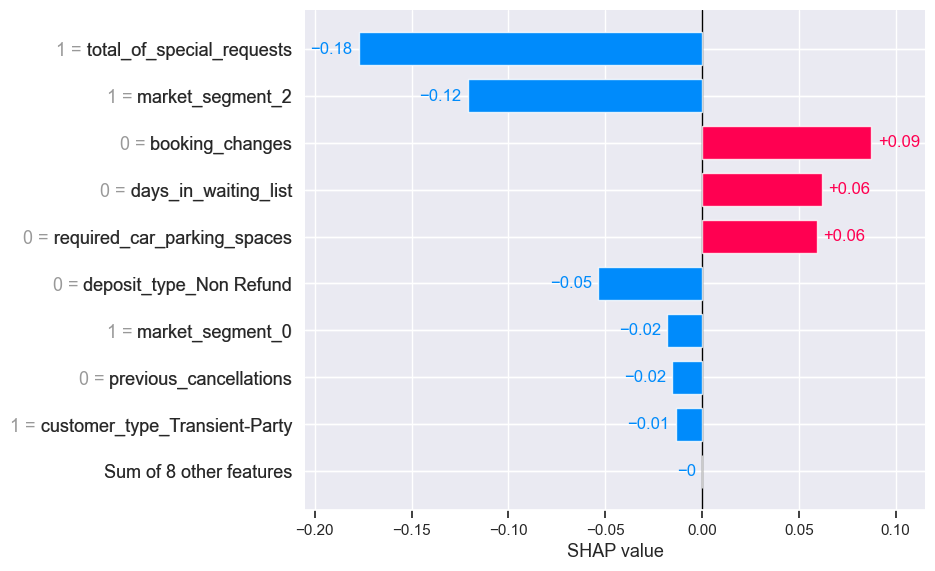

In [73]:
shap.plots.bar(shap_values[0])

> This function in the SHAP library that is used to create a bar plot of SHAP values. This plot displays the contribution of each feature to the model prediction for a particular data sample.

<a id="final"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;"> Final Model </p>

<a id="saving"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Saving Model </span></b>

In [74]:
# Fit the best XGBoost model on the entire dataset (both training and testing data)
final_model = best_xgb

# Display the final model
final_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['reserved_room_type',
                                                   'market_segment'])])),
                ('scaler', RobustScaler()),
                ('resampler', SMOTE(random_state=42)),
                ('algorithm',
                 XGBClassifier(base_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=250, n_jobs=None,
                               num_parallel_tree=None, random_state=2023, ...))])

In [83]:
# Save the final model to a file named "model_hotel_booking_cancellation.sav" using pickle
pickle.dump(final_model, open("model_hotel_booking_cancellation.sav", "wb"))

In [84]:
model_loaded = pickle.load(open('model_hotel_booking_cancellation.sav','rb'))

<a id="predict"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Predict Model </span></b>

In [77]:
# Define the data as a dictionary
new_test_data = pd.DataFrame({
    "market_segment": ["Offline TA/TO", "Groups"],
    "previous_cancellations": [0, 18],
    "reserved_room_type": ["A", "B"],
    "booking_changes": [25, 12],
    "deposit_type": ["Refundable", "Non Refund"],
    "days_in_waiting_list": [20, 2],
    "customer_type": ["Transient-Party", "Transient"],
    "required_car_parking_spaces": [8, 0],
    "total_of_special_requests": [12, 0]
})
new_test_data

,market_segment,previous_cancellations,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,Offline TA/TO,0,A,25,Refundable,20,Transient-Party,8,12
1,Groups,18,B,12,Non Refund,2,Transient,0,0


In [78]:
# Predict probabilities and the final prediction
new_test_data['cancellation_prediction'] = model_loaded.predict(new_test_data)
new_test_data

,market_segment,previous_cancellations,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,cancellation_prediction
0,Offline TA/TO,0,A,25,Refundable,20,Transient-Party,8,12,0
1,Groups,18,B,12,Non Refund,2,Transient,0,0,1


<a id="conrec"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;"> Conclusion and Recommendation </p>

<a id="cost_saving"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Cost Saving Simulation </span></b>

In [79]:
len(y_test)

572

<b>Cost</b>
- Type I error (False positive): USD59 per booking (max price for room upgrade)
- Type II error (False negative): USD110 per booking

<b>Without model</b>: 

Assume there are 60% of incorrect predictions with false positives of 20% and false negatives of 40%


In [80]:
Type_I_Error_Without_Model = 0.2 * 572 * 59
Type_II_Error_Without_Model = 0.4 * 572 * 110
Total_Financial_Lost_Without_Model = Type_I_Error_Without_Model + Type_II_Error_Without_Model
print(f'Total Financial Lost Without Model:  USD{round(Total_Financial_Lost_Without_Model,3)}')

Total Financial Lost Without Model:  USD31917.6


<b>With model</b>:

In [81]:
# Mengambil nilai dari confusion matrix
cm_test = confusion_matrix(y_test, y_pred_after_xgb)
TN, FP, FN, TP = cm_test.ravel()

# Given this confusion matrix information:
Type_I_Error_With_Model = FP * 59
Type_II_Error_With_Model = FN * 110
Total_Financial_Lost_With_Model = Type_I_Error_With_Model + Type_II_Error_With_Model
print(f'Total Financial Lost With Model: USD{round(Total_Financial_Lost_With_Model,3)}')

Total Financial Lost With Model: USD12144


In [82]:
# As a result, the model can save
cost_save = Total_Financial_Lost_Without_Model - Total_Financial_Lost_With_Model
print(f'Savings with model: USD{round(cost_save,3)}')

Savings with model: USD19773.6


<a id="conclusion"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Conclusion </span></b>

This project aims to develop a machine learning model to predict hotel booking cancellations. It focuses on minimizing false negatives. A series of machine learning experiments on the hotel's historical data have been conducted to find the best model. Overall, this project consists of 4 experiments.
- Experiment 1: This served as the baseline to evaluate the original model's performance. The best model from this experiment was compared to the results of the following experiments. 
- Experiment 2: This Utilized robust scaling to determine if scaling numeric features with outliers would improve the model's performance. 
- Experiment 3: This applied resampling methods with SMOTE and NearMiss to address the issue of imbalanced classes and enhance model performance.
- Experiment 4: This experiment combined resampling methods and hyperparameter tuning to optimize the model further. The objective was to balance the classes and fine-tune the model parameters for optimal performance.

Among the four experiments conducted, the XGBoost model in Experiment 4 successfully balanced precision and recall, significantly enhancing the prediction of hotel booking cancellations. By using this model, hotels can proactively manage room inventory and reduce potential financial losses due to sudden cancellations.

<a id="limitation"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Limitation </span></b>


- Features such as `previous_cancellations`,` booking_changes`, `days_in_waiting_list`, `required_car_parking_spaces`, and `total_of_special_requests` have specific ranges (e.g., `previous_cancellations` ranges from 0 to 26). Predictions outside these ranges may be inaccurate, as the model has not seen such values during training.
- The `country` column has been excluded from the model. While this simplifies the model, it might remove potentially valuable geographic information that could influence booking cancellations.
- Handling categorical features like `reserved_room_type` (10 types) and `customer_type` (4 types) involves converting them into numerical representations. Improper encoding can lead to loss of information or introduce biases.
- The *undefined* category in the `market_segment` column has been removed. This ensures cleaner data but may exclude some potentially useful information.
- Imbalanced classes in the target variable (e.g., more non-cancellations than cancellations) can affect model performance, especially for minority classes. Techniques like SMOTE and NearMiss help, but careful tuning is needed.

<a id="recom"></a>
# <b><span style='color:darkturquoise'>|</span><span style='color:royalblue'> Recommendation </span></b>


> Hotel Managers 
- Use the predictive model to anticipate booking cancellations and take proactive measures, such as offering special deals to at-risk bookings or overbooking slightly to account for predicted cancellations.
- Integrate the model into the booking system to provide real-time cancellation risk assessments, allowing staff to take immediate actions.
- Review and adjust booking policies based on insights from the model. For instance, consider modifying policies for customers with frequent booking changes or high special requests.
- Leverage the insights from the model to offer personalized experiences based on customer profiles. For example, offer customized services to customers with high special requests or frequent parking needs.

> Feature Directions
- Investigate additional features that may impact booking cancellations, such as customer feedback, seasonality, and booking source.
- Experiment with advanced feature engineering techniques, including interaction terms and polynomial features or RFE, to capture more complex relationships.
- Test other resampling methods or hybrid approaches to improve model performance.
- Given the time constraints, additional experiments could be beneficial. Explore different model architectures, hyperparameter tuning strategies, and cross-validation techniques to further improve the model.